In [1]:
import numpy as np
import pandas as pd

import torch 
import torchaudio
import torchaudio.transforms as AT

import matplotlib.pyplot as plt

from librosa.filters import mel as librosa_mel

from vocex import Vocex

/home/christoph.minixhofer/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# !curl -L https://free.keep.sh/XhdwMjSeqVr4lyCz/test.wav > test.wav

In [3]:
audio_args = {
    "n_fft": 1024,  
    "win_length": 1024,  
    "hop_length": 256, 
    "n_mels": 80,
}

sampling_rate=22050

# Let's load some SWB audio
# AUDIO_ROOT='/disk/scratch/swallbridge/switchboard_separated'
# audio_file = 'sw02835_B.wav'
# audio_fp = f"{AUDIO_ROOT}/{audio_file}"

# Let's load some libritts data
audio_fp = 'test.wav'


In [4]:
audio_raw, sr = torchaudio.load(audio_fp)


audio_resampled = audio_raw
if sr != sampling_rate:
    audio_resampled = torchaudio.transforms.Resample(sr, sampling_rate)(audio_raw)

audio = audio_resampled / np.abs(audio_resampled).max()

In [5]:
audio

tensor([[-0.0007, -0.0004, -0.0002,  ..., -0.0020, -0.0019, -0.0016]])

In [6]:
mel_spectrogram = AT.Spectrogram(
    n_fft=audio_args["n_fft"],
    win_length=audio_args["win_length"],
    hop_length=audio_args["hop_length"],
    pad=0,
    window_fn=torch.hann_window,
    power=2.0,
    normalized=False,
    center=True,
    pad_mode="reflect",
    onesided=True,
)

mel_basis = librosa_mel(
    sr=sampling_rate,
    n_fft=audio_args["n_fft"],
    n_mels=audio_args["n_mels"],
    fmin=0,
    fmax=8000,
)

mel_basis = torch.from_numpy(mel_basis).float()


In [7]:
def drc(x, C=1, clip_val=1e-7):
        return torch.log(torch.clamp(x, min=clip_val) * C)
    

In [8]:
# mel = mel_spectrogram(torch.tensor(batch[i]["audio"]).unsqueeze(0))
mel = mel_spectrogram(audio)
mel = torch.sqrt(mel[0])
mel = torch.matmul(mel_basis, mel)
mel = drc(mel)


In [9]:
mel_plt = mel[:,:1000]


In [10]:
# import matplotlib.pyplot as plt
display(mel_plt.shape)
display(mel_plt.max())
display(mel_plt.min())


torch.Size([80, 242])

tensor(1.2273)

tensor(-10.2357)

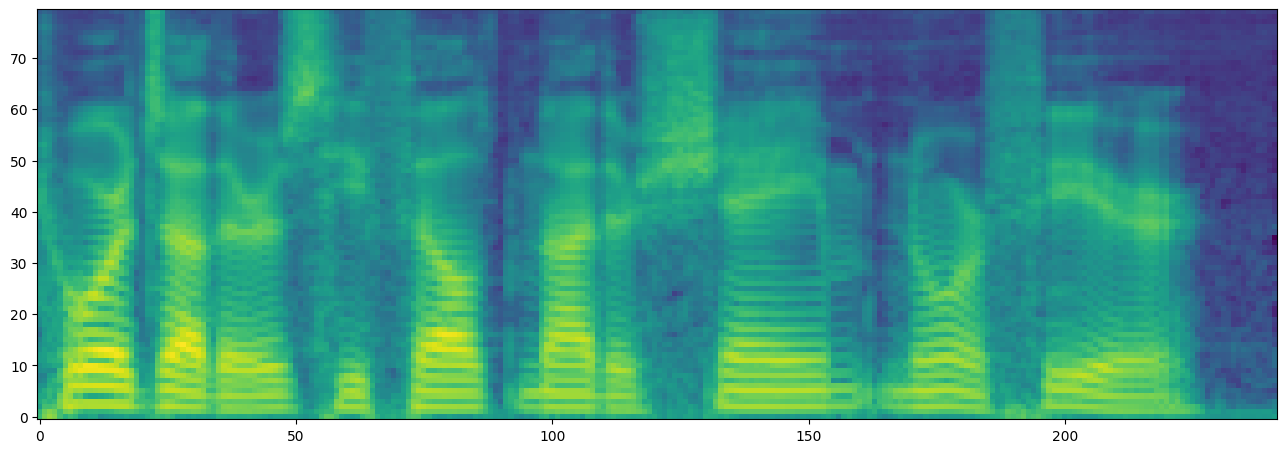

In [11]:
# Plot the spectrogram
fig, axes = plt.subplots(1,1,figsize=(16,10))
axes.imshow(mel_plt, origin='lower')


In [12]:
import IPython.display as ipd

In [47]:
audio_plt = audio[:,:sampling_rate*6]
ipd.Audio(audio_plt, rate=sampling_rate)

In [14]:
# torch.load('models/vocex_libritts_100k.pt', map_location=torch.device("cpu"))

In [70]:
model = Vocex()
model.load_state_dict(
    torch.load("models/vocex_libritts_100k.pt", map_location=torch.device("cpu")),
                     )

<All keys matched successfully>

In [109]:
mel_pad = torch.concat((mel, torch.zeros((80, 14+256))), dim=1)
mel_pad = mel_pad.T.unsqueeze(0)
mel_pad.shape

torch.Size([1, 512, 80])

In [110]:
for key in model.scalers.keys():
    model.scalers[key].is_fit = True
features = model(mel_pad, inference=True)

In [111]:
features['measures']['energy'].min(), features['measures']['energy'].max()

(tensor(-9.9750e-07), tensor(0.6471))

(0.0, 512.0)

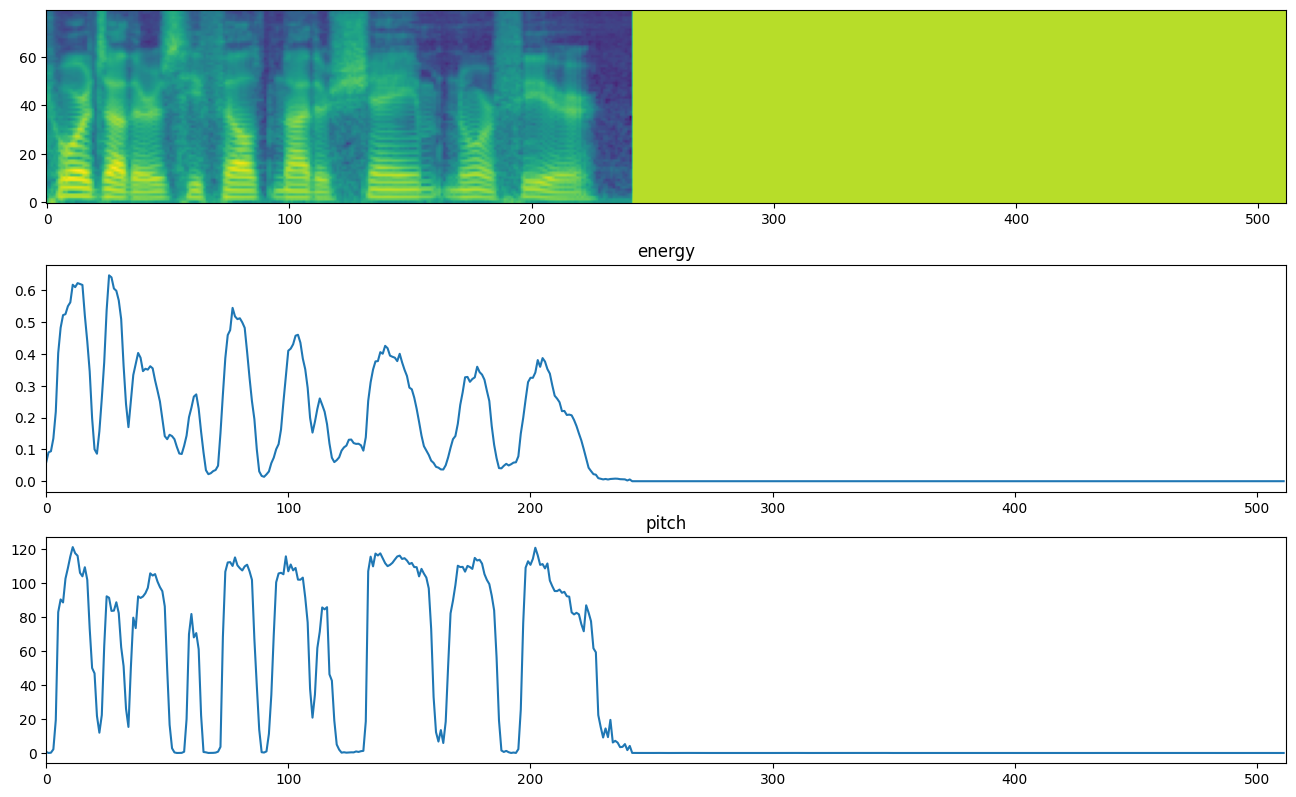

In [112]:
# Plot the spectrogram
fig, axes = plt.subplots(3,1,figsize=(16,10))
ax = axes[0]
ax.imshow(mel_pad[0].T, origin='lower')

y = features['measures']['energy'].flatten(0).detach().numpy()
x = range(len(y))
ax = axes[1]
ax.plot(x,y)
ax.set_title('energy')
ax.set_xlim(0, 512)

y = features['measures']['pitch'].flatten(0).detach().numpy()
x = range(len(y))
ax = axes[2]
ax.plot(x,y)
ax.set_title('pitch')
ax.set_xlim(0, 512)

In [114]:
import pyworld as pw
_f0, t = pw.dio(audio_plt.flatten(0).numpy().astype(np.float64), sampling_rate)    # raw pitch extractor
f0 = pw.stonemask(audio_plt.flatten(0).numpy().astype(np.float64), _f0, t, sampling_rate)  # pitch refinement

In [115]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

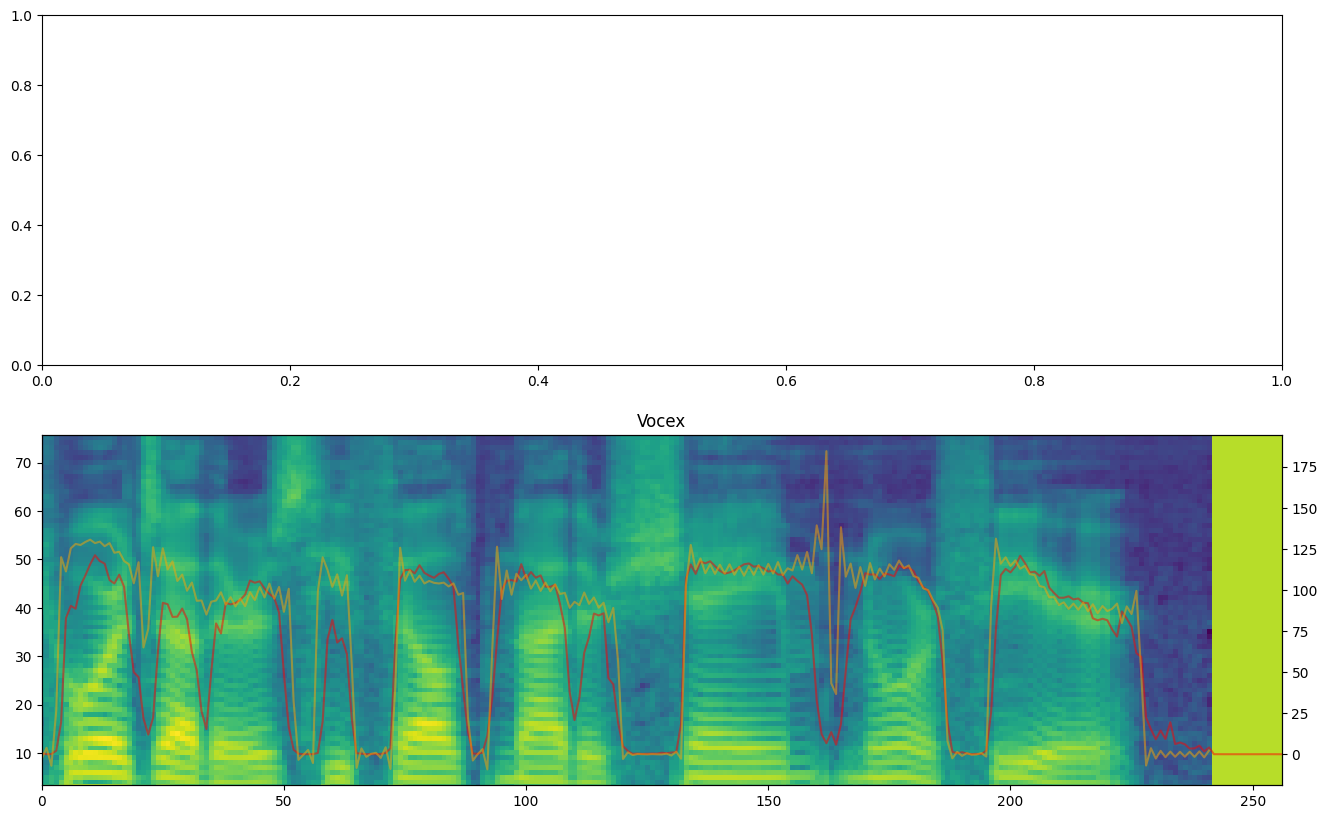

In [127]:
# Plot the spectrogram
fig, axes = plt.subplots(2,1,figsize=(16,10))
# ax = axes[0]
# ax.imshow(mel[:,400:656], origin='lower')

from scipy.signal import resample

yt = f0
xt = range(len(yt))
# ax = axes[0]
# ax.plot(x,ny)
# ax.set_title('PyWorld')
# ax.set_xlim(0, 600)

y = features['measures']['pitch'].flatten(0).detach().numpy()
x = range(len(y))
ax = axes[1]
ax2 = ax.twinx()
ax.imshow(mel_pad[0,:,:256].T, origin="lower")
ax2.plot(x,y,color="red", alpha=0.5)
ax.set_title('Vocex')
ax.set_xlim(0, 256)

ax2.plot(range(242),resample(yt, 242),color="orange",alpha=0.5)

In [120]:
len(yt)

561

In [123]:
mel.shape

torch.Size([80, 242])